# IMPORTS

In [181]:
import pandas as pd

In [182]:
df = pd.read_csv("nuclear_dataset.csv", usecols=['C1', 'C2', 'C3', 'C4'])
df

,C1,C2,C3,C4
0,0.60,0.93,0.00,0.73
1,0.66,0.55,0.45,0.49
2,1.00,0.45,0.57,0.50
3,0.48,0.87,0.00,0.75
4,0.62,0.40,0.56,0.50
5,0.78,0.27,0.71,0.50
6,0.40,0.90,0.00,0.82
7,0.64,0.44,0.54,0.54
8,0.65,0.30,0.71,0.55
9,0.45,0.86,0.00,0.73


# Informacje preferencyjne

W ramach informacji preferencyjnych należy ocenić parami warianty 0 i 15 (W skutek wyczerpywania się złóż materiałów radioaktywnych, elektrownie mogą zacząć korzystać z bardziej ubogich złóż, co przełoży się na zwiększenie ilości odpadów radioaktywnych) oraz 10 i 17 (Inflacja może znacząco wzrosnąć w przyszłości, więc minimalizacja kosztów w przyszłości powinny być ważniejsza niż koszty aktualne)

In [183]:
df[df.index.isin([0, 15, 10, 17])]

,C1,C2,C3,C4
0,0.60,0.93,0.00,0.73
10,0.61,0.54,0.38,0.49
15,0.44,0.95,0.00,0.90
17,0.76,0.06,1.00,0.60


Wariant 0 > Wariant 15 - $ U(W0) > U(W15) $

Wariant 10 > Wariant 17 - $ U(W10) > U(W17) $



In [184]:
preferences = [
    [0, 15],  # 0 > 15
    [10, 17],  # 10 > 17
    [18, 19],
    [21, 19],
    [19, 16],
]

In [185]:
from pulp import *

In [186]:
# Utworzenie problemu UTA-GMS
problem = LpProblem("uta-gms", LpMaximize)

# Utworzenie zmiennej maksymalizowanej
epsilon = LpVariable("epsilon")

# Utworzenie zmiennych decyzyjnych dla każdego kryterium w problemie programowania matematycznego
decision_variables = {}
for column in df.columns:
    unique_values = df[column].sort_values().unique()
    decision_variables[column] = [LpVariable(f"x_{column}_{value}", 0, 1) for value in unique_values]

# Wagi na danych kryteriach
problem += decision_variables['C3'][0] == 2*decision_variables['C1'][0]
problem += decision_variables['C2'][0] == 3*decision_variables['C1'][0]

# Dodanie ograniczenia na normalizację (maksymalna użyteczność globalna równa 1)
# Ponieważ wszystkie kryteria są typu koszt, możemy założyć, że wariant o minimalnych wartościach jest najlepszy
problem += lpSum([x[0] for x in decision_variables.values()]) == 1

# Dodanie ograniczenia na normalizację (minimalna użyteczność globalna równa 0)
# Ponieważ wszystkie kryteria są typu koszt, możemy założyć, że wariant o maksymalnych wartościach jest najgorszy
problem += lpSum([x[-1] for x in decision_variables.values()]) == 0

# Dodanie ograniczeń na monotoniczność funkcji cząstkowych
# W problemie używana jest funkcja ogólna, więc nie ma potrzeby wyliczania interpolacji liniowej
# Wystarczy dodać ograniczenia, które gwarantują, że kolejne zmienne decyzyjne mają nierosnące wartości użyteczności
for column in df.columns:
    for i in range(len(decision_variables[column])-1):
        problem += decision_variables[column][i] >= decision_variables[column][i+1]

# Dodanie ograniczeń związanych z preferencjami decydenta
for preference in preferences:
    alt_1 = df.loc[preference[0]].to_dict()
    alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
        
    alt_2 = df.loc[preference[1]].to_dict()
    alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]

    print(alt_1_variables, alt_2_variables)

    problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables) + epsilon

[x_C1_0.6, x_C2_0.93, x_C3_0.0, x_C4_0.73] [x_C1_0.44, x_C2_0.95, x_C3_0.0, x_C4_0.9]
[x_C1_0.61, x_C2_0.54, x_C3_0.38, x_C4_0.49] [x_C1_0.76, x_C2_0.06, x_C3_1.0, x_C4_0.6]
[x_C1_0.35, x_C2_0.91, x_C3_0.0, x_C4_0.98] [x_C1_0.64, x_C2_0.22, x_C3_0.81, x_C4_0.65]
[x_C1_0.32, x_C2_0.83, x_C3_0.0, x_C4_0.94] [x_C1_0.64, x_C2_0.22, x_C3_0.81, x_C4_0.65]
[x_C1_0.64, x_C2_0.22, x_C3_0.81, x_C4_0.65] [x_C1_0.68, x_C2_0.4, x_C3_0.65, x_C4_0.6]


In [187]:
for constraint in problem.constraints.values():
    print(constraint)

-2*x_C1_0.32 + x_C3_0.0 = 0
-3*x_C1_0.32 + x_C2_0.03 = 0
x_C1_0.32 + x_C2_0.03 + x_C3_0.0 + x_C4_0.49 = 1
x_C1_1.0 + x_C2_1.0 + x_C3_1.0 + x_C4_1.0 = 0
x_C1_0.32 - x_C1_0.34 >= 0
x_C1_0.34 - x_C1_0.35 >= 0
x_C1_0.35 - x_C1_0.4 >= 0
x_C1_0.4 - x_C1_0.44 >= 0
x_C1_0.44 - x_C1_0.45 >= 0
x_C1_0.45 - x_C1_0.48 >= 0
x_C1_0.48 - x_C1_0.59 >= 0
x_C1_0.59 - x_C1_0.6 >= 0
x_C1_0.6 - x_C1_0.61 >= 0
x_C1_0.61 - x_C1_0.62 >= 0
x_C1_0.62 - x_C1_0.64 >= 0
x_C1_0.64 - x_C1_0.65 >= 0
x_C1_0.65 - x_C1_0.66 >= 0
x_C1_0.66 - x_C1_0.68 >= 0
x_C1_0.68 - x_C1_0.69 >= 0
x_C1_0.69 - x_C1_0.71 >= 0
x_C1_0.71 - x_C1_0.73 >= 0
x_C1_0.73 - x_C1_0.74 >= 0
x_C1_0.74 - x_C1_0.76 >= 0
x_C1_0.76 - x_C1_0.78 >= 0
x_C1_0.78 - x_C1_0.8 >= 0
x_C1_0.8 - x_C1_0.83 >= 0
x_C1_0.83 - x_C1_0.87 >= 0
x_C1_0.87 - x_C1_1.0 >= 0
x_C2_0.03 - x_C2_0.06 >= 0
x_C2_0.06 - x_C2_0.22 >= 0
x_C2_0.22 - x_C2_0.24 >= 0
x_C2_0.24 - x_C2_0.25 >= 0
x_C2_0.25 - x_C2_0.27 >= 0
x_C2_0.27 - x_C2_0.3 >= 0
x_C2_0.3 - x_C2_0.4 >= 0
x_C2_0.4 - x_C2_0.44 

In [188]:
problem += epsilon

In [189]:
problem.solve(solver=GLPK())

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /tmp/37ed24fbad7241af9e2068401b8629a2-pulp.lp -o /tmp/37ed24fbad7241af9e2068401b8629a2-pulp.sol
Reading problem data from '/tmp/37ed24fbad7241af9e2068401b8629a2-pulp.lp'...
82 rows, 78 columns, 201 non-zeros
171 lines were read
GLPK Simplex Optimizer 5.0
82 rows, 78 columns, 201 non-zeros
Preprocessing...
77 rows, 74 columns, 188 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  3.000e+00  ratio =  3.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 77
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (1)
*    51: obj =   2.500000000e-01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (137931 bytes)
Writing basic solution to '/tmp/37ed24fbad7241af9e2068401b8629a2-pulp.sol'...


1

In [190]:
#Retrieve the status of the solution:
status = LpStatus[problem.status]
print("Status:", status)

#Retrieve the solution as a dictionary with variable names and their values:
solution = {variable.name: variable.varValue for variable in problem.variables()}
print("Solution:", solution)

Status: Optimal
Solution: {'epsilon': 0.25, 'x_C1_0.32': 0.166667, 'x_C1_0.34': 0.166667, 'x_C1_0.35': 0.166667, 'x_C1_0.4': 0.0833333, 'x_C1_0.44': 0.0833333, 'x_C1_0.45': 0.0833333, 'x_C1_0.48': 0.0833333, 'x_C1_0.59': 0.0833333, 'x_C1_0.6': 0.0833333, 'x_C1_0.61': 0.0833333, 'x_C1_0.62': 0.0833333, 'x_C1_0.64': 0.0833333, 'x_C1_0.65': 0.0, 'x_C1_0.66': 0.0, 'x_C1_0.68': 0.0, 'x_C1_0.69': 0.0, 'x_C1_0.71': 0.0, 'x_C1_0.73': 0.0, 'x_C1_0.74': 0.0, 'x_C1_0.76': 0.0, 'x_C1_0.78': 0.0, 'x_C1_0.8': 0.0, 'x_C1_0.83': 0.0, 'x_C1_0.87': 0.0, 'x_C1_1.0': 0.0, 'x_C2_0.03': 0.5, 'x_C2_0.06': 0.416667, 'x_C2_0.22': 0.416667, 'x_C2_0.24': 0.25, 'x_C2_0.25': 0.25, 'x_C2_0.27': 0.25, 'x_C2_0.3': 0.25, 'x_C2_0.4': 0.25, 'x_C2_0.44': 0.25, 'x_C2_0.45': 0.25, 'x_C2_0.49': 0.25, 'x_C2_0.54': 0.25, 'x_C2_0.55': 0.25, 'x_C2_0.83': 0.25, 'x_C2_0.86': 0.25, 'x_C2_0.87': 0.25, 'x_C2_0.9': 0.25, 'x_C2_0.91': 0.25, 'x_C2_0.93': 0.25, 'x_C2_0.95': 0.0, 'x_C2_0.97': 0.0, 'x_C2_1.0': 0.0, 'x_C3_0.0': 0.333333, '

# Wykresy użyteczności

In [191]:
import matplotlib.pyplot as plt

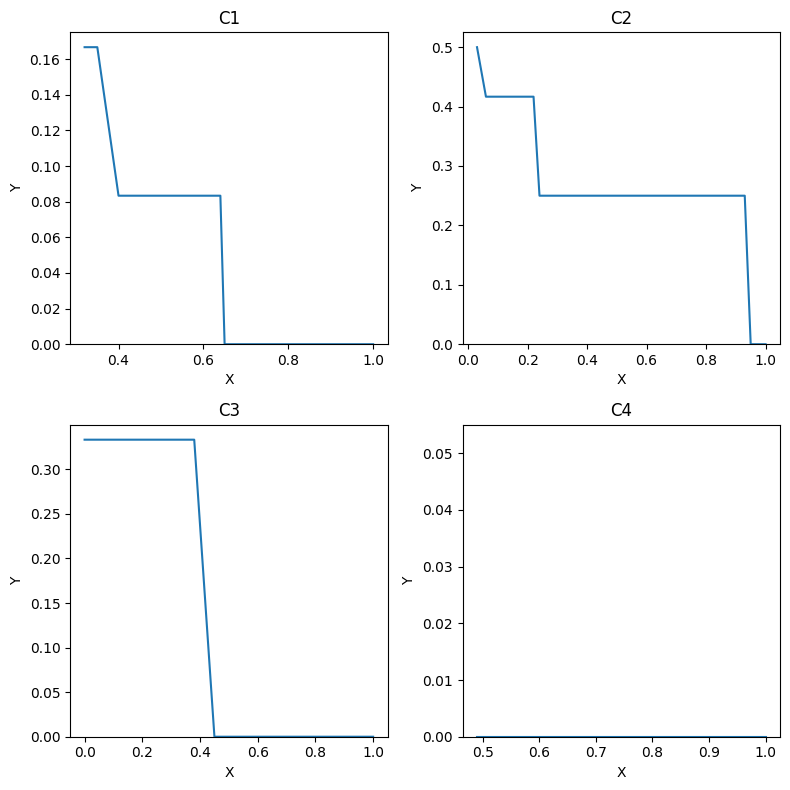

In [192]:
utilities = {criterion: [] for criterion in df.columns}
for k, v in solution.items():
    if k.startswith("x_"):
        criterion = k.split("_")[1]
        x = float(k.split("_")[2])
        y = v
        utilities[criterion].append((x, y))

num_plots = len(utilities)
cols = 2
rows = num_plots // cols
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

for i, (k, v) in enumerate(utilities.items()):
    x = [point[0] for point in v]
    y = [point[1] for point in v]
    row = i // cols
    col = i % cols
    ax = axs[row, col]
    
    ax.plot(x, y)
    ax.set_title(k)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Wartości użyteczności oraz ranking wszystkich wariantów

In [198]:
global_utilities = []
for k, alternative in df.iterrows():
    s = 0
    for column in df.columns:
        s += next((point[1] for point in utilities[column] if point[0] == alternative[column]), None)
    global_utilities.append(s)

df_u = df.copy()
df_u['U'] = global_utilities
df_u['rank'] = df_u['U'].rank(ascending=False, method='min')
df_u.sort_values(by='rank')

,C1,C2,C3,C4,U,rank
21,0.32,0.83,0.00,0.94,0.750000,1.0
18,0.35,0.91,0.00,0.98,0.750000,1.0
0,0.60,0.93,0.00,0.73,0.666666,3.0
3,0.48,0.87,0.00,0.75,0.666666,3.0
6,0.40,0.90,0.00,0.82,0.666666,3.0
9,0.45,0.86,0.00,0.73,0.666666,3.0
10,0.61,0.54,0.38,0.49,0.666666,3.0
19,0.64,0.22,0.81,0.65,0.500000,8.0
23,0.73,0.03,1.00,0.63,0.500000,9.0
14,0.87,0.03,1.00,0.61,0.500000,9.0


# Wartość funkcji celu

In [199]:
solution['epsilon']

0.25